In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from util.TrainRoutine import AutoEncTrainRoutine
from util.DPMERFGenerator import DPMERFGenerator
from util.Evaluator import Evaluator

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We want to use the DPMERF algorithm on time series data. But we will not work on time series directly, because it does not model the temporal relation correctly. Instead we will train an AE first and use DPMERF on the encoding space, where there is no notion of time and ordering.

In [2]:
emb_dim = 32

In [3]:
ae = AutoEncTrainRoutine(emb_dim=emb_dim)

------------------------------
Initialising Autoencoder with:
RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)
Training on cuda
------------------------------


In [4]:
ae.load_model(f"lstmae_180_embed{emb_dim}.pth")

In [14]:
ae.encode_train_data(f"data/normal_training_encoded_embed{emb_dim}.csv")

In [9]:
dpmerfgen_priv = DPMERFGenerator(path_2_data=f"data/normal_training_encoded_embed{emb_dim}.csv", input_size=10, is_priv=True)

In [10]:
dpmerfgen_priv.train_generator(mini_batch_size=0.1, lr=1e-2)

minibatch:  7125
total number of datapoints in the training data is 71253
random freq (1000, 32)
adding DP noise
Starting Training
epoch # and running loss are  [0, 3.0894263722002506]
epoch # and running loss are  [100, 0.003838913020445034]
epoch # and running loss are  [200, 0.002499466441804543]
epoch # and running loss are  [300, 0.0017995410016737878]
epoch # and running loss are  [400, 0.0015731797611806542]
epoch # and running loss are  [500, 0.0020813053124584258]
epoch # and running loss are  [600, 0.0014941733606974594]
epoch # and running loss are  [700, 0.0017699448217172176]
epoch # and running loss are  [800, 0.0014604789830627851]
epoch # and running loss are  [900, 0.0020083715207874775]
epoch # and running loss are  [1000, 0.0012985531793674454]
epoch # and running loss are  [1100, 0.0017979572658077814]
epoch # and running loss are  [1200, 0.0014680872263852507]
epoch # and running loss are  [1300, 0.0025142066297121346]
epoch # and running loss are  [1400, 0.0013166

In [13]:
dpmerfgen_priv.generate(fname=f"enc_gen_embed_priv_{emb_dim}.csv")

In [14]:
decoded_gen_embed = ae.decode_data(path_encoded_data=f"data/generated/enc_gen_embed_priv_{emb_dim}.csv")
pd.DataFrame(decoded_gen_embed).to_csv(f"data/generated/normal_train_180_priv_embed{emb_dim}_dpmerf.csv")

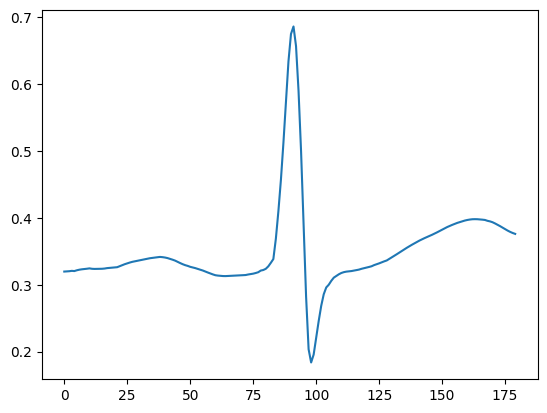

In [15]:
plt.plot(decoded_gen_embed[20])

In [16]:
ae_gen_priv = AutoEncTrainRoutine(training_data_path=f"data/generated/normal_train_180_priv_embed{emb_dim}_dpmerf.csv")

------------------------------
Initialising Autoencoder with:
RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)
Training on cuda
------------------------------


In [17]:
model, history = ae_gen_priv.train_model()

loss: 35.587357  [    1/71253]
loss: 1.707290  [10001/71253]
loss: 15.830179  [20001/71253]
loss: 6.849802  [30001/71253]
loss: 23.440472  [40001/71253]
loss: 3.167861  [50001/71253]
loss: 1.763589  [60001/71253]
loss: 1.669685  [70001/71253]
Epoch 1: train loss = 6.873487090509589, val loss = 4.452490385342319
loss: 9.835133  [    1/71253]
loss: 0.881858  [10001/71253]
loss: 1.401940  [20001/71253]
loss: 1.054252  [30001/71253]
loss: 1.297368  [40001/71253]
loss: 0.187128  [50001/71253]
loss: 0.514416  [60001/71253]
loss: 1.357945  [70001/71253]
Epoch 2: train loss = 2.656624331835497, val loss = 4.41822380841486
loss: 0.975171  [    1/71253]
loss: 0.697278  [10001/71253]
loss: 4.619019  [20001/71253]
loss: 4.689069  [30001/71253]
loss: 3.382739  [40001/71253]
loss: 0.549438  [50001/71253]
loss: 1.241758  [60001/71253]
loss: 2.232834  [70001/71253]
Epoch 3: train loss = 1.9800913576785117, val loss = 4.041197210490086
loss: 4.096262  [    1/71253]
loss: 2.484885  [10001/71253]
loss: 1

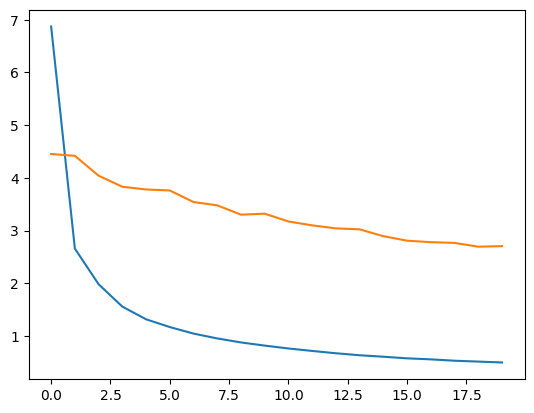

In [18]:
plt.plot(history["train"])
plt.plot(history["val"])

In [19]:
ae_gen_priv.save_model(f"dpmerf_priv_embed{emb_dim}.pth")

In [20]:
evaluator = Evaluator(ae_gen_priv.test_normal_ds, ae_gen_priv.test_anomalie_ds, ae_gen_priv.model)

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([180, 1])) that is different to the input size (torch.Size([1, 180, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


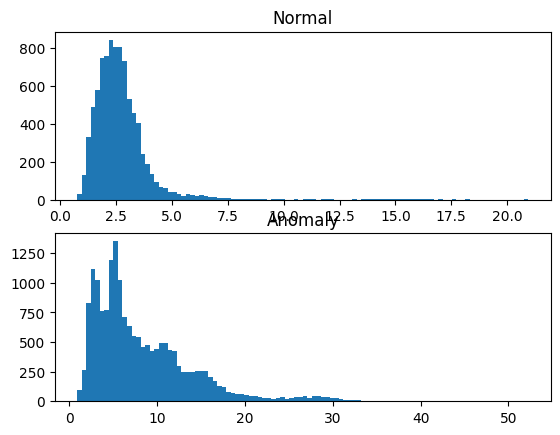

In [21]:
plt.figure()

plt.subplot(2,1,1)
plt.hist(evaluator.loss_normal, bins=100)
plt.title("Normal")

plt.subplot(2,1,2)
plt.hist(evaluator.loss_anomaly, bins=100)
plt.title("Anomaly")

plt.show()

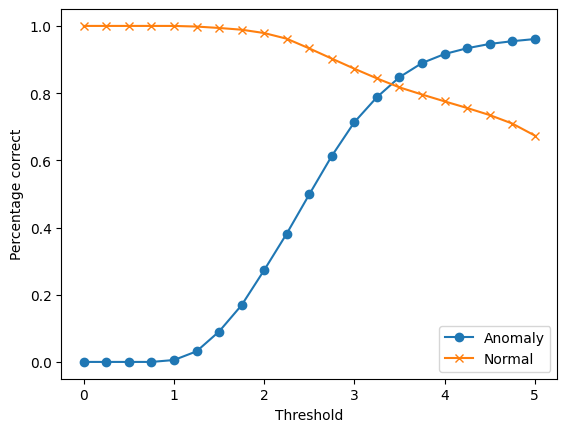

In [22]:
corr_normal, corr_anomaly = evaluator.find_threshold()
plt.plot(np.linspace(0,5,21), corr_normal, marker="o")
plt.plot(np.linspace(0,5,21), corr_anomaly, marker="x")
plt.xlabel("Threshold")
plt.ylabel("Percentage correct")
plt.legend(["Anomaly", "Normal"])
plt.show()

In [23]:
predictions_normal, predictions_anomaly = evaluator.predict_class(3.25)


In [24]:
evaluator.evaluate(predictions_normal, predictions_anomaly)

Acc: 0.825502105302381
Precision: 0.7110176446450553
Recall: 0.7878822325792884
F1: 0.7474791048800216
